In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy

from google.colab import runtime


In [2]:
#Hyperparameters
lr = 0.00005
momentum = 0 #default = 0
weight_decay = 0.02 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 64
epochs = 75

In [3]:
transforms = {
    'train':
    #Composing several transforms together
    transforms.Compose(
        [
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.GaussianBlur(1),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomPerspective(),
            transforms.ToTensor(), #To tensor object
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
            transforms.Resize((256,256)) #Speeds up model without losing too much information
        ]),

    'trainOld':
    transforms.Compose(
        [
            transforms.TrivialAugmentWide(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256)),
        ]
    ),

    'val':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ]),

    'test':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ])
}

In [4]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 344862509/344862509 [00:25<00:00, 13293224.17it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1832498.35it/s]


100%|██████████| 14989/14989 [00:00<00:00, 20066524.95it/s]


In [5]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [6]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
#dataloaders = {
#    'train': train_dataloader,
#    'val': val_dataloader
#}

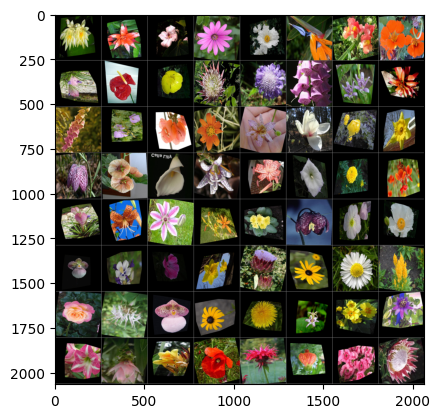

In [8]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [9]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.conv_block_1 = nn.Sequential(
        #Conv layer to extract features
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, #Size of the kernel it looks at
                  stride=1, #How far it steps between kernels
                  padding=1), #Added to the edges to stop the miage decreasing in size
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
         nn.BatchNorm2d(hidden_units),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64*64,
                  out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024,
                  out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512,
                  out_features=output_shape)

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [11]:
model = CNNv2(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(

In [12]:
#Loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(),
#                            lr=lr,
#                            momentum=momentum,
#                            weight_decay=weight_decay,
#                            dampening=dampening)
optimiser = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)


In [13]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.train()
  running_loss, running_corrects = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    running_loss += loss.item()
    running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"Train Error: \nAccuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")
  return ave_loss, corrects


In [14]:
#Validate the models progress using the validation data
def valTest(dataloader, model, loss_fn, split):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.eval()
  running_loss, running_corrects = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)

      running_loss += loss.item()
      running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"{split} Error: \n Accuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")

  return ave_loss, corrects


In [2]:
def pltHist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(121)
  plt.plot(hist['train_loss'],'-o')
  plt.plot(hist['val_loss'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation loss')

  plt.subplot(122)
  plt.plot(hist['train_accuracy'],'-o')
  plt.plot(hist['val_accuracy'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation Accuracy')

In [16]:
def trainValLoop(model, loss_fn, optimiser, epochs):
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} -------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimiser)
    val_loss, val_acc = valTest(val_dataloader, model, loss_fn, 'Validate')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

  hist = {'train_loss':train_loss_hist, 'train_accuracy':train_acc_hist,
          'val_loss':val_loss_hist, 'val_accuracy':val_acc_hist}
  pltHist(hist)
  valTest(test_dataloader, model, loss_fn, 'Test')

  return hist


Epoch 1/75 -------------------------------
Train Error: 
Accuracy: 2.25%, Avg loss: 5.052929 

Validate Error: 
 Accuracy: 1.76%, Avg loss: 4.562272 

Epoch 2/75 -------------------------------
Train Error: 
Accuracy: 9.12%, Avg loss: 4.081799 

Validate Error: 
 Accuracy: 8.14%, Avg loss: 4.063063 

Epoch 3/75 -------------------------------
Train Error: 
Accuracy: 12.35%, Avg loss: 3.706663 

Validate Error: 
 Accuracy: 14.51%, Avg loss: 3.694336 

Epoch 4/75 -------------------------------
Train Error: 
Accuracy: 19.12%, Avg loss: 3.385300 

Validate Error: 
 Accuracy: 17.55%, Avg loss: 3.588620 

Epoch 5/75 -------------------------------
Train Error: 
Accuracy: 19.71%, Avg loss: 3.213839 

Validate Error: 
 Accuracy: 20.69%, Avg loss: 3.411000 

Epoch 6/75 -------------------------------
Train Error: 
Accuracy: 25.98%, Avg loss: 2.957290 

Validate Error: 
 Accuracy: 23.43%, Avg loss: 3.323071 

Epoch 7/75 -------------------------------
Train Error: 
Accuracy: 33.92%, Avg loss: 2

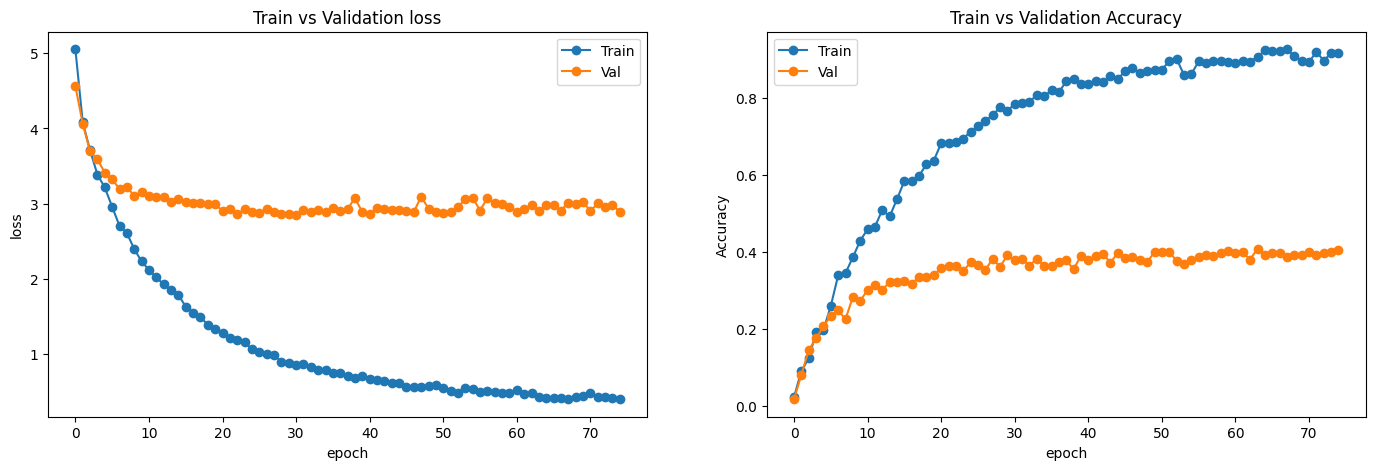

In [17]:
hist = trainValLoop(model, loss_fn, optimiser, epochs)

In [18]:
PATH = './CNNv1.pth'
torch.save(model.state_dict(), PATH)

In [19]:
print("#Hyperparameters")
print(f"lr = {lr:.5f}")
print(f"momentum = {momentum}")
print(f"weight_decay = {weight_decay}")
print(f"dampening = {dampening}")
print()
print("#Other")
print(f"batch_size = {batch_size}")
print(f"epochs = {epochs}")

#Hyperparameters
lr = 0.00005
momentum = 0
weight_decay = 0.02
dampening = 0

#Other
batch_size = 64
epochs = 75


In [20]:
print(hist)

{'train_loss': [5.052929401397705, 4.081799238920212, 3.706663101911545, 3.385300412774086, 3.2138389945030212, 2.9572895616292953, 2.7017058432102203, 2.6090188920497894, 2.3949291184544563, 2.2307332307100296, 2.119635969400406, 2.018277883529663, 1.9257823303341866, 1.8509920239448547, 1.7840106710791588, 1.6302615031599998, 1.5513193234801292, 1.4951409101486206, 1.3853486478328705, 1.3383262231945992, 1.2831003107130527, 1.2055640146136284, 1.1834265142679214, 1.1606871373951435, 1.060081660747528, 1.0309096835553646, 0.9988946206867695, 0.9856694862246513, 0.8975912593305111, 0.8854862228035927, 0.848169595003128, 0.8723158687353134, 0.8270464688539505, 0.7864875644445419, 0.7821528129279613, 0.7464709989726543, 0.7523933984339237, 0.7058170288801193, 0.673551432788372, 0.7052877880632877, 0.6604559570550919, 0.6530807968229055, 0.635290514677763, 0.6095463633537292, 0.6141523644328117, 0.5632326938211918, 0.5556548777967691, 0.5621155463159084, 0.5698716659098864, 0.584868399426

In [ ]:
#Stops Google stealing my credits
runtime.unassign()

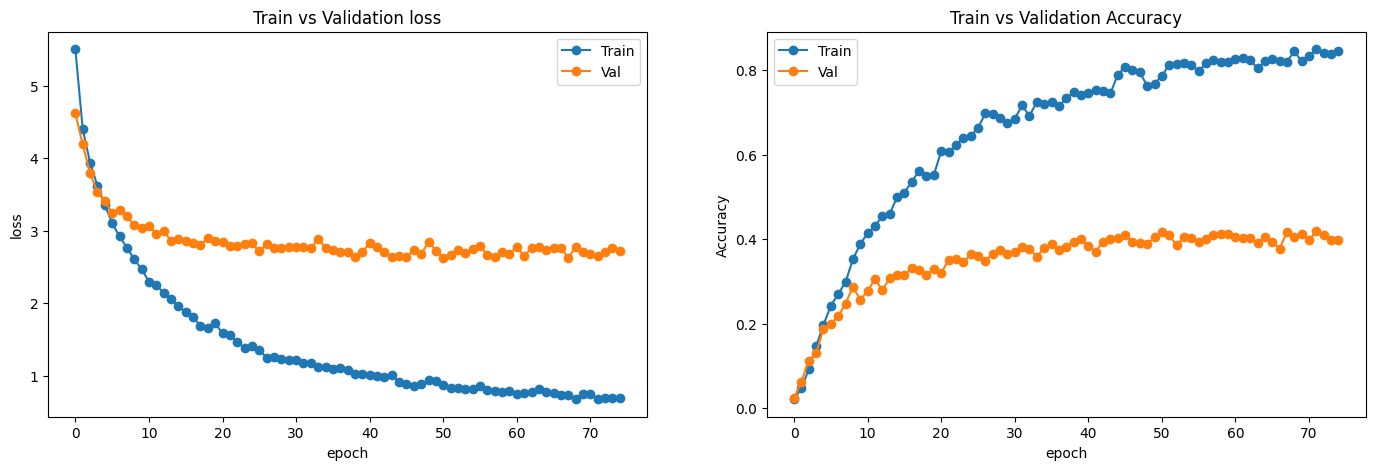

In [5]:
histVik = {'train_loss': [5.5008140206336975, 4.39636304974556, 3.938842222094536, 3.6158574372529984, 3.3549892008304596, 3.103615328669548, 2.919704481959343, 2.766319826245308, 2.6048020124435425, 2.4719468504190445, 2.2965127378702164, 2.24921727925539, 2.1405009031295776, 2.054493136703968, 1.967368170619011, 1.8723777160048485, 1.8045103698968887, 1.6909383982419968, 1.6640976443886757, 1.7213626727461815, 1.584119752049446, 1.5576417818665504, 1.4585413709282875, 1.3876879513263702, 1.4060565158724785, 1.3549524769186974, 1.2479200661182404, 1.254988193511963, 1.229830875992775, 1.217771839350462, 1.2127954922616482, 1.1723270639777184, 1.1778041571378708, 1.1159872934222221, 1.124925296753645, 1.088006529957056, 1.1104719750583172, 1.0794157162308693, 1.0247646793723106, 1.030349276959896, 1.0092010907828808, 0.9959609620273113, 0.9801309108734131, 1.0131890028715134, 0.9087448865175247, 0.8897546902298927, 0.859260767698288, 0.8892028145492077, 0.934352308511734, 0.924677774310112, 0.8666737303137779, 0.8311854489147663, 0.8267241604626179, 0.8222386129200459, 0.8169344253838062, 0.8611368089914322, 0.801959939301014, 0.7857087962329388, 0.7695043310523033, 0.7881885133683681, 0.7461172193288803, 0.7570652328431606, 0.7715899683535099, 0.8230037279427052, 0.7691345401108265, 0.7561647444963455, 0.7287545688450336, 0.7295719757676125, 0.6851099655032158, 0.7516774572432041, 0.7504389248788357, 0.675926934927702, 0.6906546540558338, 0.6950874179601669, 0.6953147873282433], 'train_accuracy': [0.020588235294117647, 0.04607843137254902, 0.09117647058823529, 0.14607843137254903, 0.19607843137254902, 0.24215686274509804, 0.2696078431372549, 0.2980392156862745, 0.3519607843137255, 0.38823529411764707, 0.4137254901960784, 0.43137254901960786, 0.453921568627451, 0.4598039215686274, 0.49901960784313726, 0.5098039215686274, 0.5362745098039216, 0.5617647058823529, 0.55, 0.5519607843137255, 0.6078431372549019, 0.6058823529411764, 0.6235294117647059, 0.6392156862745098, 0.6450980392156863, 0.6627450980392157, 0.6980392156862745, 0.6970588235294117, 0.6862745098039216, 0.6754901960784314, 0.6852941176470588, 0.7166666666666667, 0.692156862745098, 0.7245098039215686, 0.7205882352941176, 0.7245098039215686, 0.7147058823529412, 0.7333333333333333, 0.7490196078431373, 0.7411764705882353, 0.746078431372549, 0.753921568627451, 0.7509803921568627, 0.7450980392156863, 0.7892156862745098, 0.8088235294117647, 0.8, 0.7950980392156862, 0.7637254901960784, 0.7686274509803922, 0.7862745098039216, 0.8137254901960784, 0.8156862745098039, 0.8176470588235294, 0.8137254901960784, 0.7980392156862746, 0.8166666666666667, 0.8245098039215686, 0.8186274509803921, 0.8196078431372549, 0.8274509803921568, 0.8284313725490197, 0.8245098039215686, 0.8049019607843138, 0.8215686274509804, 0.8264705882352941, 0.8225490196078431, 0.8205882352941176, 0.8450980392156863, 0.8215686274509804, 0.8333333333333334, 0.85, 0.8401960784313726, 0.8382352941176471, 0.8450980392156863], 'val_loss': [4.616889238357544, 4.188763439655304, 3.7895465344190598, 3.5285023152828217, 3.406976491212845, 3.242396205663681, 3.2848135083913803, 3.197787418961525, 3.0799668058753014, 3.0382342785596848, 3.064896196126938, 2.955493740737438, 2.9916914105415344, 2.8636043295264244, 2.8897500559687614, 2.8626389279961586, 2.8316052556037903, 2.8016303703188896, 2.8967382460832596, 2.851347714662552, 2.844473622739315, 2.7866858541965485, 2.789623200893402, 2.809841923415661, 2.8231419399380684, 2.7172439359128475, 2.8090159744024277, 2.755731165409088, 2.762440077960491, 2.7715226635336876, 2.770785130560398, 2.7728183642029762, 2.756305955350399, 2.884439244866371, 2.763972494751215, 2.7376623898744583, 2.6993456967175007, 2.7083624340593815, 2.6334287896752357, 2.703705795109272, 2.827068742364645, 2.7722952850162983, 2.711642049252987, 2.64008167386055, 2.645510006695986, 2.6358195543289185, 2.72744657099247, 2.674745559692383, 2.844549745321274, 2.7255148515105247, 2.626645762473345, 2.6657681837677956, 2.73084032535553, 2.6920742839574814, 2.7409381344914436, 2.786032136529684, 2.6678709127008915, 2.6416863054037094, 2.7037449702620506, 2.6788580492138863, 2.776828143745661, 2.652834564447403, 2.759438391774893, 2.7786882668733597, 2.7285907194018364, 2.763010773807764, 2.763108156621456, 2.626058302819729, 2.769099857658148, 2.711540922522545, 2.680009186267853, 2.646326992660761, 2.7006685473024845, 2.756279829889536, 2.715831108391285], 'val_accuracy': [0.022549019607843137, 0.061764705882352944, 0.11176470588235295, 0.12941176470588237, 0.18725490196078431, 0.2, 0.21666666666666667, 0.24705882352941178, 0.28627450980392155, 0.2568627450980392, 0.27647058823529413, 0.3058823529411765, 0.27941176470588236, 0.30686274509803924, 0.31470588235294117, 0.3156862745098039, 0.3303921568627451, 0.32745098039215687, 0.3156862745098039, 0.32941176470588235, 0.3196078431372549, 0.35, 0.3519607843137255, 0.34509803921568627, 0.3637254901960784, 0.3607843137254902, 0.34901960784313724, 0.36470588235294116, 0.37450980392156863, 0.3637254901960784, 0.3686274509803922, 0.3813725490196078, 0.37745098039215685, 0.35784313725490197, 0.37941176470588234, 0.3872549019607843, 0.3735294117647059, 0.38235294117647056, 0.3931372549019608, 0.40098039215686276, 0.38333333333333336, 0.37058823529411766, 0.3931372549019608, 0.40098039215686276, 0.40294117647058825, 0.4107843137254902, 0.39215686274509803, 0.39019607843137255, 0.38823529411764707, 0.403921568627451, 0.4166666666666667, 0.4088235294117647, 0.38529411764705884, 0.40490196078431373, 0.4019607843137255, 0.3941176470588235, 0.40098039215686276, 0.4088235294117647, 0.41274509803921566, 0.41274509803921566, 0.403921568627451, 0.40294117647058825, 0.4019607843137255, 0.3911764705882353, 0.403921568627451, 0.3931372549019608, 0.37745098039215685, 0.4166666666666667, 0.40588235294117647, 0.41274509803921566, 0.39705882352941174, 0.4196078431372549, 0.4088235294117647, 0.3980392156862745, 0.3980392156862745]}

pltHist(histVik)